# Processo Seletivo CIS 2025.1

## Felipe Lopes Gibin Duarte - 231025207

## Importação de Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Questão 1

Existem valores faltantes ou outliers no dataset? Se sim, como você abordaria o
tratamento dessas inconsistências? Explique as técnicas que utilizaria para lidar com essas questões.

#### 1.1 Análise inicial dos dados

In [ ]:
# Carregar o dataset
df = pd.read_csv('diabetes.csv')

# Visualizar as primeiras linhas
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,0.0,33.6,627.0,50,1
1,1,85.0,66.0,29.0,0.0,26.6,351.0,31,0
2,8,183.0,64.0,0.0,0.0,23.3,672.0,32,1
3,1,89.0,66.0,23.0,94.0,28.1,167.0,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2288.0,33,1


#### 1.2 Verificando zeros inválidos

Algumas variáveis podem conter zeros onde isso seria fisicamente impossível, como: Glucose, BloodPressure, SkinThickness, Insulin, BMI. Vamos verificar se isso ocorre:


In [ ]:
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI','DiabetesPedigreeFunction']
df[cols_with_invalid_zeros].describe()
(df[cols_with_invalid_zeros] == 0).sum()


,0
Glucose,5
BloodPressure,34
SkinThickness,222
Insulin,374
BMI,10
DiabetesPedigreeFunction,0


#### 1.3 Substituindo os zeros pela mediana

In [ ]:
df_clean = df.copy()
for col in cols_with_invalid_zeros:
    df_clean[col] = df_clean[col].replace(0, np.nan)
    median_value = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_value)

df = df_clean

#### 1.4 Identificação de outliers

Identificaremos outliers usando boxplots e o método IQR

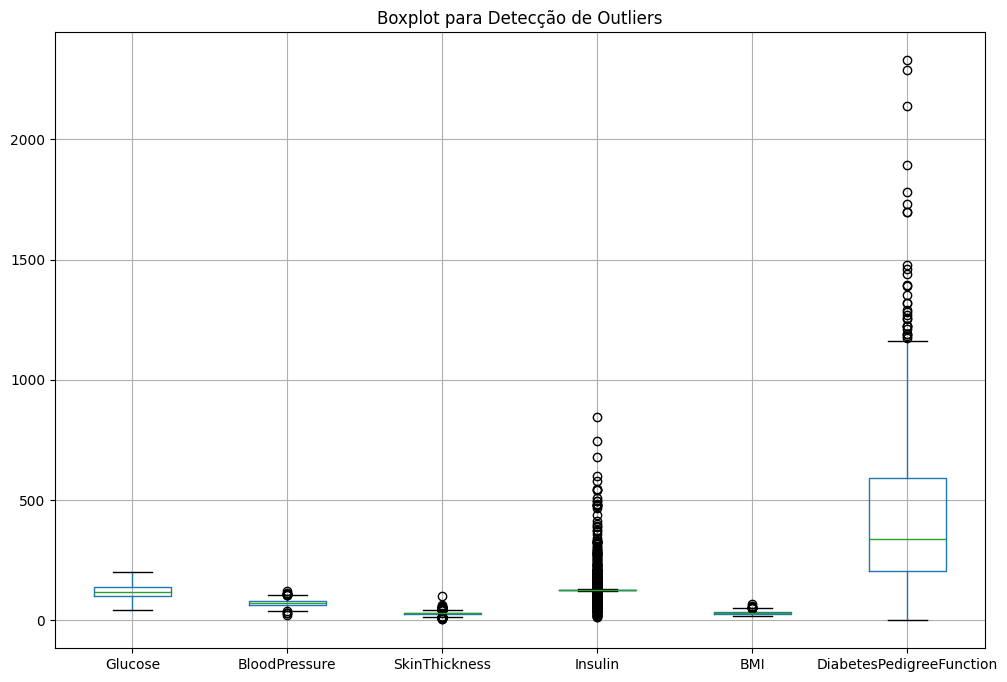

In [ ]:
# Boxplot geral
plt.figure(figsize=(12, 8))
df[cols_with_invalid_zeros].boxplot()
plt.title("Boxplot para Detecção de Outliers")
plt.show()

In [ ]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Exemplo com BMI
outliers_BMI = detect_outliers_iqr(df, 'BMI')
print(f'Outliers em BMI: {len(outliers_BMI)}')


Outliers em BMI: 10


#### 1.5 Tratando os outliers

Para tratar os outliers do conjunto de dados, vamos limitar os valores aos percentis 5% e 95%. Os valores que sofrerem o capping serão ajustados para o valor do percentil correspondente (5% ou 95%), de forma a evitar que afetem a analise sem excluir completamente sua influência.

In [ ]:
def cap_outliers(data, column):
    lower = data[column].quantile(0.05)
    upper = data[column].quantile(0.95)
    data[column] = np.clip(data[column], lower, upper)

for col in cols_with_invalid_zeros:
    cap_outliers(df, col)


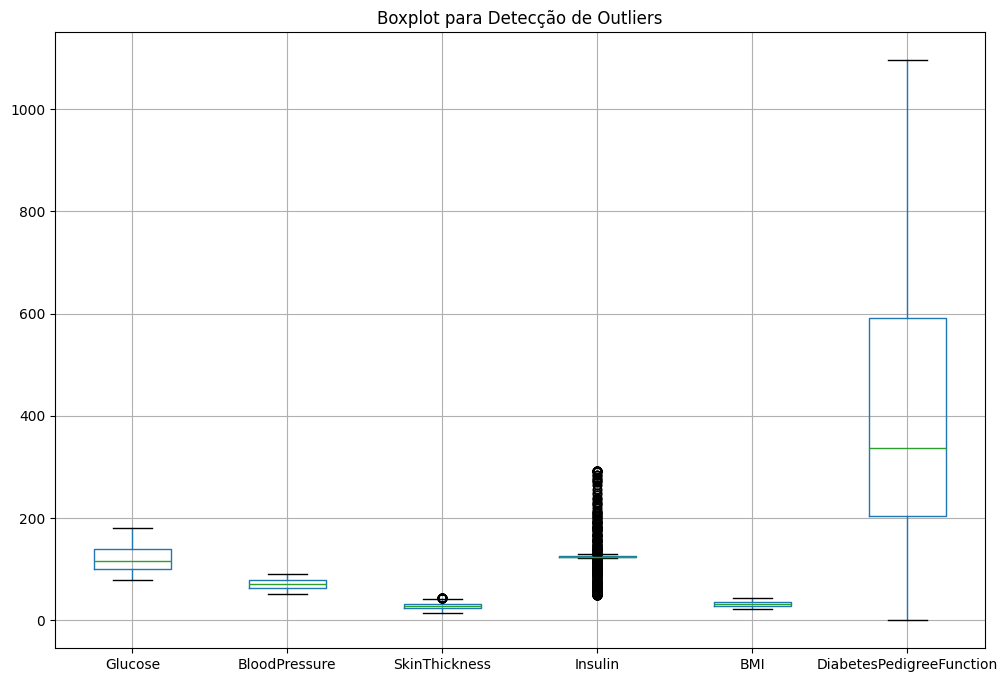

In [ ]:
# Novo Boxplot, apos o capping
plt.figure(figsize=(12, 8))
df[cols_with_invalid_zeros].boxplot()
plt.title("Boxplot para Detecção de Outliers")
plt.show()

#### 1.6 Resumo

Identifiquei zeros biologicamente implausíveis em Glucose, BloodPressure, SkinThickness, Insulin e BMI, substituindo esses zeros por NaN para tratamento explícito. Após isso, troquei os NaNs pela mediana.


Utilizei o método IQR (1.5*IQR) para detecção e implementei capping nos percentis 5 e 95 para tratamento. Contudo, alguns "outliers" podem ser valores relevantes em contextos clínicos, por isso a estratégia conservadora do capping para a coluna Insulin, que possui uma distribuição extremamente assimétrica.

### Questão 2

Como as principais variáveis (Glucose, BloodPressure, BMI, etc.) estão
distribuídas? Utilize histogramas e boxplots para representar visualmente essas
distribuições e analise as características de cada uma.

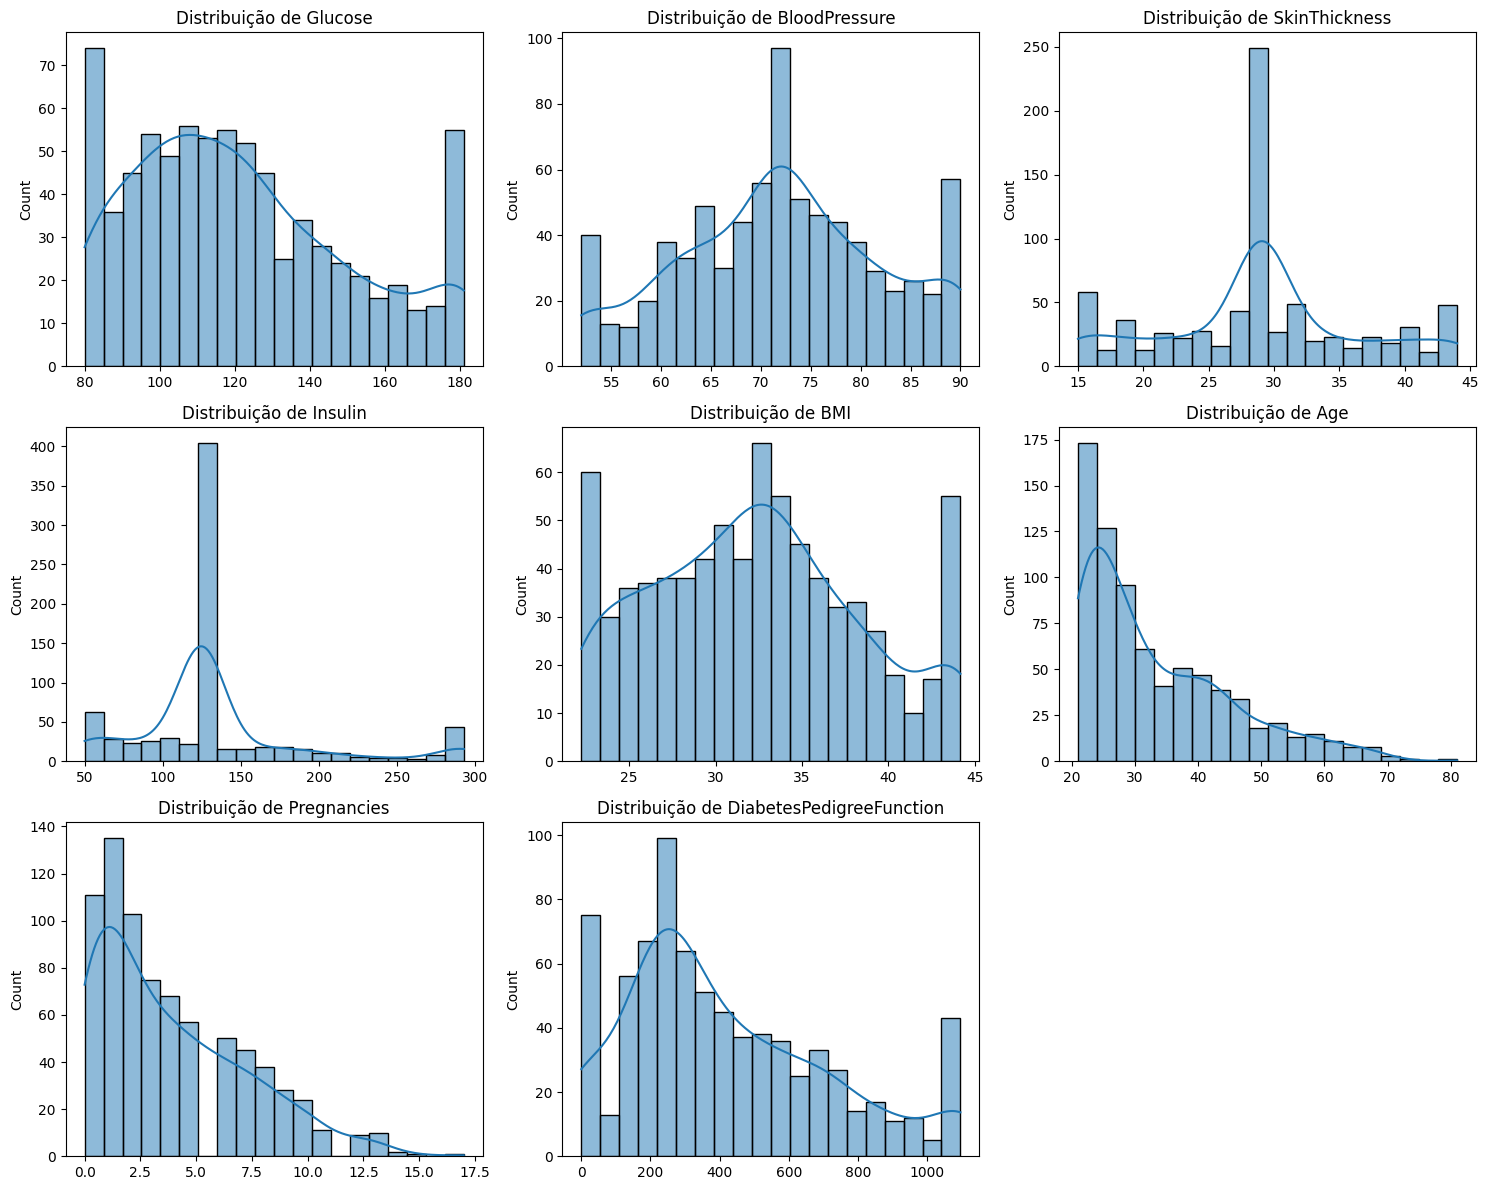

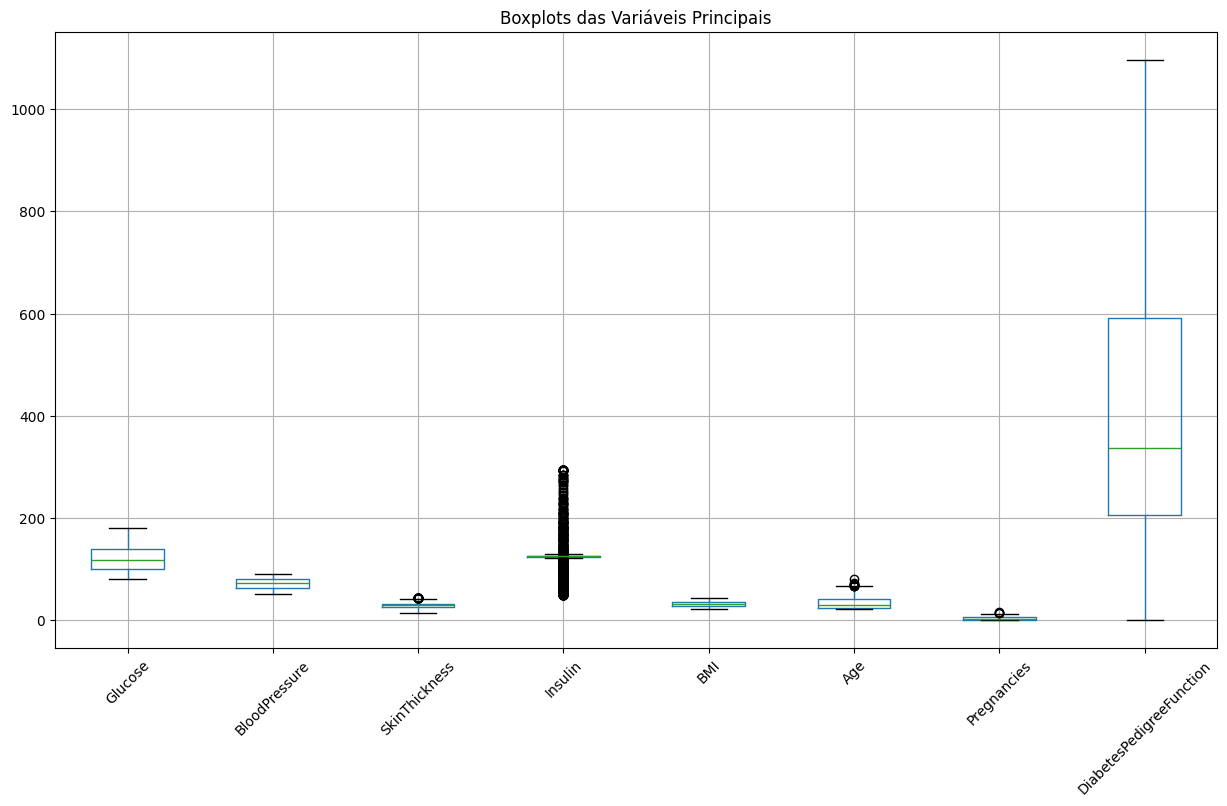

In [ ]:
#Variáveis principaist
main_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction']
plt.figure(figsize=(15, 12))

# Histogramas com curvas de densidade
for i, var in enumerate(main_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[var], kde=True, bins=20)
    plt.title(f'Distribuição de {var}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(15, 8))
df_clean[main_vars].boxplot()
plt.title('Boxplots das Variáveis Principais')
plt.xticks(rotation=45)
plt.show()

A princípio, observamos distribuições esperadas para as variáveis sob observação. Porém, a análise torna-se um pouco mais complexa pela falta de unidades associadas às variáveis. Uma análise breve dos resultados:

1)Glucose com assimetria leve à direita. Valores típicos entre 70-100 mg/dL em jejum.

2)Assumindo que a pressão arterial seja a diastólica, média dentro do padrão (<80 mm Hg)

3)Difícil de avaliar Skin Thickness, qual a área do corpo em que foi medido? Qual a unidade? Os valores medios estão na faixa de 1.5-2 mm.

4)Insulin com assimetria forte à direita. Valores típicos entre 5-25 mcU/mL, chegando a 200 mcU/mL após alimentação.

5)BMI com assimetria à direita, indicando sobrepeso. Moda em 33, BMI feminino médio no Brasil: 26

6 e 7) Age e Pregnancies sem comentários.

8)Não encontrei valores de referência para DiabetesPedigreeFunction

### Questão 3

Existe uma correlação entre a idade dos indivíduos e a presença de diabetes?
Realize uma análise estatística (como teste de correlação) e utilize gráficos (como scatter plot ou boxplot) para ilustrar essa relação.

#### 3.1 Análise simples Idade x Diabetes

In [ ]:
#Médias de idade para cada grupo
media_idade = df.groupby('Outcome')['Age'].mean()
print("Média de idade:")
print(f"Sem diabetes: {media_idade[0]:.1f} anos")
print(f"Com diabetes: {media_idade[1]:.1f} anos")

Média de idade:
Sem diabetes: 31.2 anos
Com diabetes: 37.1 anos


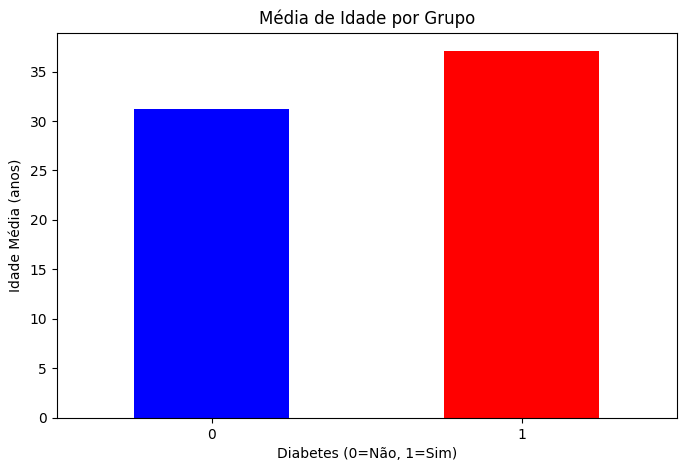

In [ ]:
#Gráfico de barras simples
plt.figure(figsize=(8, 5))
df.groupby('Outcome')['Age'].mean().plot(kind='bar', color=['blue', 'red'])
plt.title('Média de Idade por Grupo')
plt.xlabel('Diabetes (0=Não, 1=Sim)')
plt.ylabel('Idade Média (anos)')
plt.xticks(rotation=0)
plt.show()

#### 3.1 Teste de correlação

In [ ]:
correlacao, p_valor = pearsonr(df['Age'], df['Outcome'])
print(f"Correlação: {correlacao:.3f}")
print(f"Valor-p: {p_valor:.3f}")

Correlação: 0.238
Valor-p: 0.000


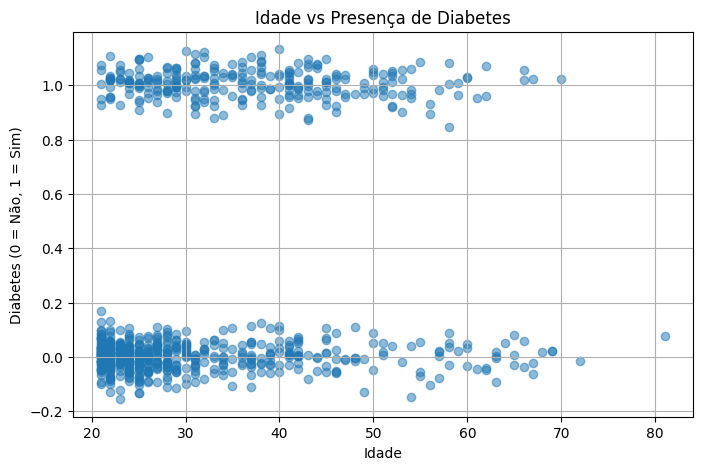

In [ ]:
# Adiciona ruído para evitar sobreposição dos pontos
jitter = 0.05 * np.random.randn(len(df))

plt.figure(figsize=(8, 5))
plt.scatter(df['Age'], df['Outcome'] + jitter, alpha=0.5)
plt.xlabel('Idade')
plt.ylabel('Diabetes (0 = Não, 1 = Sim)')
plt.title('Idade vs Presença de Diabetes')
plt.grid(True)
plt.show()


#### 3.3 Interpretação

Existe uma correlação positiva e significativa (p-value < 0.05) entre idade e a presença de diabetes. Pessoas mais velhas têm uma chance maior de desenvolver diabetes, embora a correlação não seja muito forte. Observamos que pessoas com a doença são em média 6 anos mais velhas.

### Questão 4

Quais variáveis apresentam maior correlação com a presença de diabetes? Quais
variáveis parecem ser as mais indicativas da presença de diabetes?

In [ ]:
# Calcular correlações com a variável Outcome
correlacoes = df.corr()['Outcome'].sort_values(ascending=False)

# Mostrar as correlações
print("Correlação com Diabetes (Outcome):")
print(correlacoes[1:])  # Excluindo a correlação consigo mesma

Correlação com Diabetes (Outcome):
Glucose                     0.495856
BMI                         0.297392
Insulin                     0.239808
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.213825
DiabetesPedigreeFunction    0.186899
BloodPressure               0.172007
Name: Outcome, dtype: float64


Observamos que as 3 variáveis mais indicativas de diabetes são:

1)Glucose: Índices altos de açúcar no sangue são o principal indicador clínico de diabetes, já que o paciente não produz insulina suficiente ou apresenta resistência à sua ação. A insulina é o hormônio responsável por permitir a entrada da glicose nas células. A falta dela gera um excesso dessas moléculas no sangue.

2)BMI: O BMI é uma medida que relaciona peso e altura e serve como um indicativo de obesidade. Níveis elevados estão associados à resistência à insulina, levando ao desenvolvimento de diabetes tipo 2.

3)Insulin: A insulina é o hormônio chave no controle da glicemia. Níveis anormais de insulina no sangue indicam uma resistência a essa, que não consegue agir de forma adequada. Já níveis muito baixos indicam uma deficiência na produção desse hormônio, comum na diabetes tipo 1.

### Questão 5

Existe uma relação entre o IMC dos pacientes e o diagnóstico de diabetes?
Compare os valores médios de IMC entre os grupos com e sem diabetes, e
analise a diferença estatisticamente

In [ ]:
#Médias de IMC para cada grupo
media_imc = df.groupby('Outcome')['BMI'].mean()
print("Média de IMC:")
print(f"Sem diabetes: {media_imc[0]:.1f}")
print(f"Com diabetes: {media_imc[1]:.1f}")

Média de IMC:
Sem diabetes: 31.0
Com diabetes: 34.8


Sim, há uma relação estatística entre o IMC (BMI) de pacientes com e sem diabetes. Conforme foi descoberto na questão anterior, há um índice de correlação de 0.2973 entre a variável de interesse e a doença, o que é explicitado com as médias de quem tem a doença sendo 3.8 pontos maior.

### Questão 6

Existe um valor específico de glicose que pode ser considerado crítico para o
diagnóstico de diabetes? Utilize gráficos de dispersão e cálculos estatísticos para investigar esse ponto e definir um limite crítico, se possível.

#### 6.1 Limiar clínico

O limiar clínico comumente reconhecido é de 126 mg/dL. Assim, vamos explorar a distribuição dos pacientes diante desse limiar e, depois disso, definir um limiar próprio para os dados desse dataset. Para tal, vamos testar diferentes valores para o limiar e ver qual fornece o melhor equilíbrio entre sensibilidade (mede verdadeiros positivos) e especificidade(mede verdadeiros negativos).

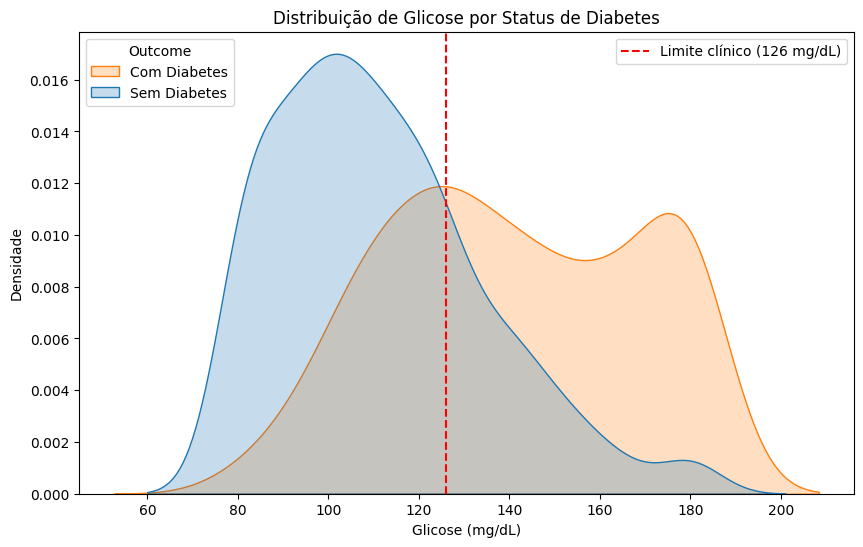

In [ ]:
# Gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Glucose', hue='Outcome', common_norm=False, fill=True)
plt.axvline(x=126, color='red', linestyle='--', label='Limite clínico (126 mg/dL)')
plt.title('Distribuição de Glicose por Status de Diabetes')
plt.xlabel('Glicose (mg/dL)')
plt.ylabel('Densidade')
first_legend = plt.legend(title='Outcome', labels=['Com Diabetes', 'Sem Diabetes'], loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=[plt.Line2D([0], [0], color='red', linestyle='--', label='Limite clínico (126 mg/dL)')])
plt.show()

In [ ]:
# Definir vários limiares possíveis
limiares = range(80, 200, 2)  # Limiar entre 80 e 200, com um passo de 2
resultados = []

for limiar in limiares:
    # Gerar as previsões binárias com base no limiar
    y_pred = (df['Glucose'] >= limiar).astype(int)

    # Calcular a matriz de confusão
    tn, fp, fn, tp = confusion_matrix(df['Outcome'], y_pred).ravel()

    # Calcular sensibilidade (recall) e especificidade
    sensibilidade = tp / (tp + fn)
    especificidade = tn / (tn + fp)

    # Armazenar os resultados para cada limiar
    resultados.append((limiar, sensibilidade, especificidade))

# Converter para DataFrame para fácil visualização
df_limiares = pd.DataFrame(resultados, columns=['Limiar', 'Sensibilidade', 'Especificidade'])

# Encontrar o ponto de equilíbrio (sensibilidade ≈ especificidade)
limiar_otimo = df_limiares.iloc[(df_limiares['Sensibilidade'] - df_limiares['Especificidade']).abs().idxmin()]

print(f"Limiar ótimo: {limiar_otimo['Limiar']}")
print(f"Sensibilidade: {limiar_otimo['Sensibilidade']:.4f}")
print(f"Especificidade: {limiar_otimo['Especificidade']:.4f}")


Limiar ótimo: 122.0
Sensibilidade: 0.7164
Especificidade: 0.7040


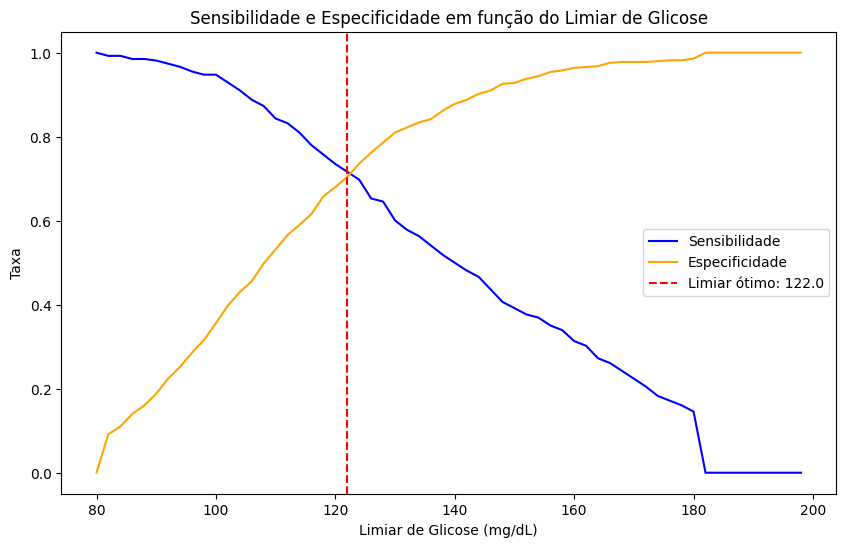

In [ ]:
#Plot da sensibilidade e especificidade
plt.figure(figsize=(10, 6))
plt.plot(df_limiares['Limiar'], df_limiares['Sensibilidade'], label='Sensibilidade', color='blue')
plt.plot(df_limiares['Limiar'], df_limiares['Especificidade'], label='Especificidade', color='orange')
plt.axvline(x=limiar_otimo['Limiar'], color='red', linestyle='--', label=f'Limiar ótimo: {limiar_otimo["Limiar"]}')
plt.xlabel('Limiar de Glicose (mg/dL)')
plt.ylabel('Taxa')
plt.title('Sensibilidade e Especificidade em função do Limiar de Glicose')
plt.legend()
plt.show()


### Questão 7

Treine um modelo de árvore de decisão para prever a presença de diabetes com
base nas variáveis do dataset. Qual foi a acurácia obtida? Discuta os resultados e possíveis melhorias para o modelo.

#### 7.1 Preparação dos dados e treinamento do modelo

In [ ]:
# Selecionar features e target
X = df.drop(['Outcome', 'Age'], axis=1)  # Removendo colunas não usadas
y = df['Outcome']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar e treinar o modelo
modelo_arvore = DecisionTreeClassifier(random_state=42)
modelo_arvore.fit(X_train, y_train)

# Previsões
y_pred = modelo_arvore.predict(X_test)

#### 7.2 Avaliação do modelo

In [ ]:
# Acurácia
acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {acuracia:.2%}")

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia do modelo: 71.00%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       151
           1       0.57      0.65      0.61        80

    accuracy                           0.71       231
   macro avg       0.69      0.70      0.69       231
weighted avg       0.72      0.71      0.71       231



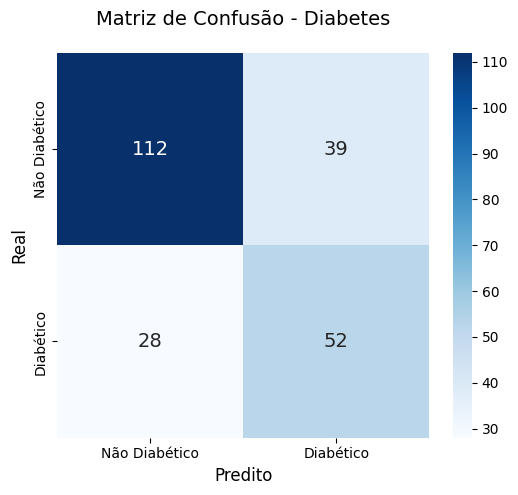

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, class_names=['Não Diabético', 'Diabético']):
    # Fazer previsões
    y_pred = model.predict(X_test)

    # Gerar matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    # Plotar a matriz de confusão com o heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={'size': 14},)

    # Adicionar rótulos e título
    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.title('Matriz de Confusão - Diabetes', pad=20, fontsize=14)

    # Ajustar o layout e mostrar o gráfico
    plt.show()

# Exemplo de uso
plot_confusion_matrix(modelo_arvore, X_test, y_test)


#### 7.3 Visualização do modelo

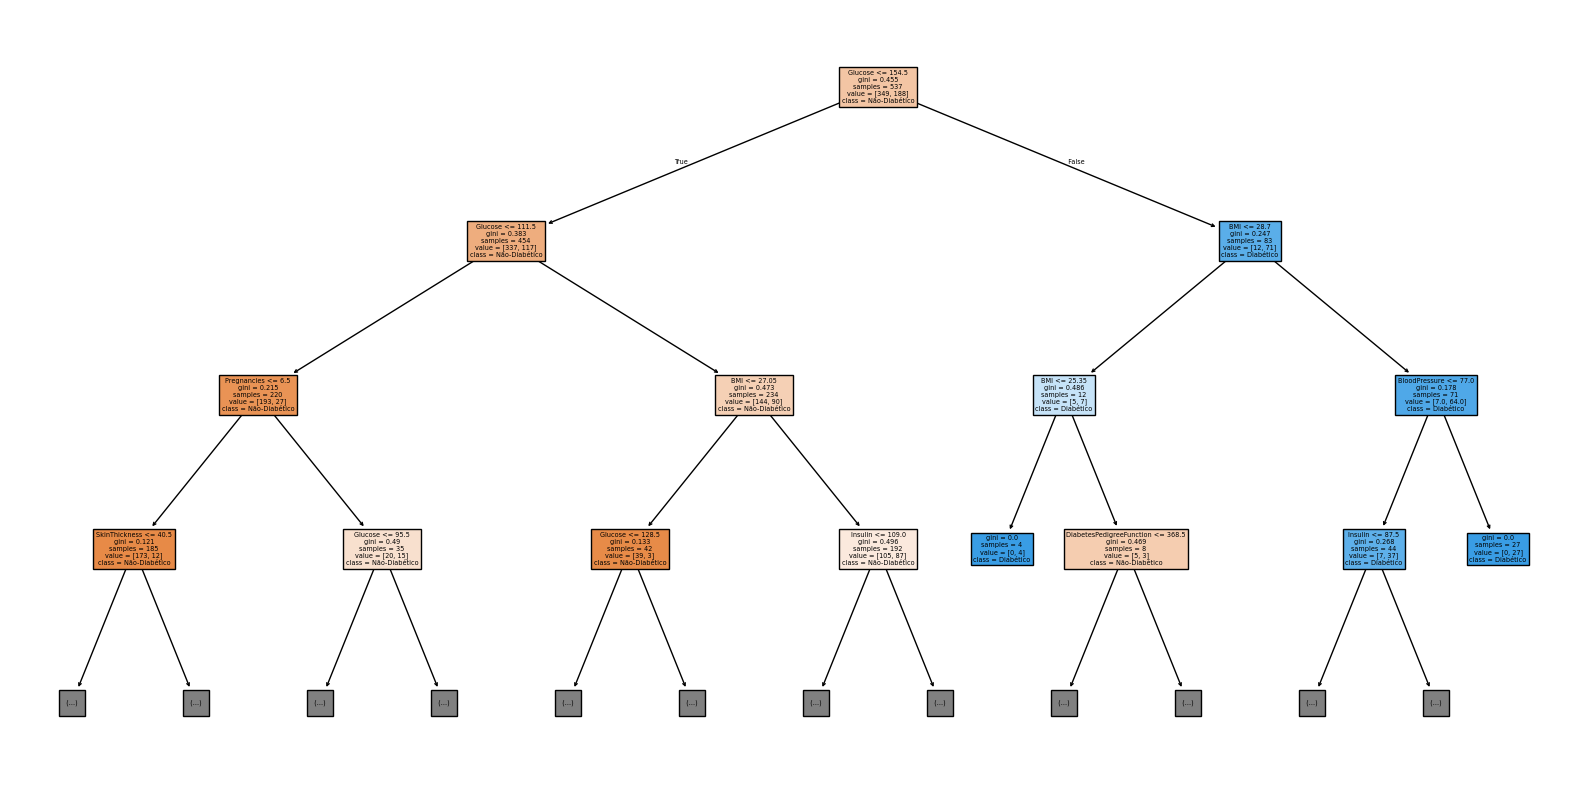

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(modelo_arvore, feature_names=X.columns,
          class_names=['Não-Diabético', 'Diabético'],
          filled=True, max_depth=3)
plt.show()

#### 7.4 Análise

O modelo inicial teve um desempenho razoável, com cerca de 70% de acurácia, mas mostrou algumas limitações em identificar corretamente todos os casos de diabetes (classe 1). Isso se deve em parte pela assimetria das classes no dataset e aos limites do modelo (árvore de decisão), que tende a se ajustar demais aos dados de treino e pode não generalizar bem para dados novos. Pode-se melhorar o desempenho ao 1) Balancear as classes; 2) Ajustar os hiperparâmetros da árvore, a fim de evitar o overfitting; 3) Testar outros modelos mais robustos.

### Questão 8

A variável DiabetesPedigreeFunction está relacionada à presença de diabetes?
Pacientes com histórico familiar de diabetes apresentam maior risco? Realize
uma análise exploratória e estatística para verificar essa relação.

#### 8.1 Médias e visualização

In [ ]:
print("Estatísticas descritivas:")
print(df_clean.groupby('Outcome')['DiabetesPedigreeFunction'].describe())

print("\nDiferença de médias:")
print(f"Sem diabetes: {df[df['Outcome'] == 0]['DiabetesPedigreeFunction'].mean():.2f}")
print(f"Com diabetes: {df[df['Outcome'] == 1]['DiabetesPedigreeFunction'].mean():.2f}")

Estatísticas descritivas:
         count        mean         std   min     25%    50%     75%      max
Outcome                                                                     
0        500.0  373.183220  274.614081  0.34  186.75  299.0  527.25  1095.65
1        268.0  488.503022  314.888600  0.34  254.00  422.5  719.50  1095.65

Diferença de médias:
Sem diabetes: 373.18
Com diabetes: 488.50


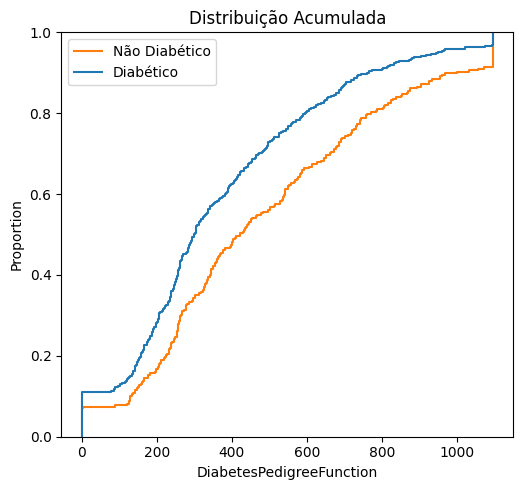

In [ ]:
#Visualização Gráfica da relação

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
sns.ecdfplot(data=df_clean, x='DiabetesPedigreeFunction', hue='Outcome')
plt.title('Distribuição Acumulada')
plt.xlabel('DiabetesPedigreeFunction')
plt.legend(['Não Diabético', 'Diabético'])

plt.tight_layout()
plt.show()

#### 8.2 Conclusão

A diferença das médias de 'DiabetesPedigreeFunction' entre pacientes com e sem diabetes, somadas à correlação encontrada na questão 4, de 0.17, explicitam a interdependência estatisticamente significativa entre a doença e questões hereditárias. Dessa forma, o score funciona como um indicador de risco familiar.

### Questão 9

Pacientes com mais de 50 anos têm taxas de diabetes mais altas do que
pacientes mais jovens? Utilize estatísticas descritivas e gráficos comparativos
para demonstrar as diferenças entre esses dois grupos etários.

#### 9.1 Análise por faixa etária

In [ ]:
# Criar grupos etários
df['Faixa_Etaria'] = pd.cut(df['Age'],
                            bins=[20, 50, 100],
                            labels=['≤50 anos', '>50 anos'])

# Calcular taxas de diabetes
taxa_diabetes = df.groupby('Faixa_Etaria',observed =True)['Outcome'].mean() * 100

In [ ]:
print("Taxa de Diabetes por Faixa Etária:")
print(taxa_diabetes.round(1).astype(str) + '%')

print("\nDistribuição:")
print(df.groupby('Faixa_Etaria',observed = True)['Outcome'].describe())

Taxa de Diabetes por Faixa Etária:
Faixa_Etaria
≤50 anos    33.5%
>50 anos    46.9%
Name: Outcome, dtype: object

Distribuição:
              count      mean       std  min  25%  50%  75%  max
Faixa_Etaria                                                    
≤50 anos      687.0  0.334789  0.472260  0.0  0.0  0.0  1.0  1.0
>50 anos       81.0  0.469136  0.502156  0.0  0.0  0.0  1.0  1.0


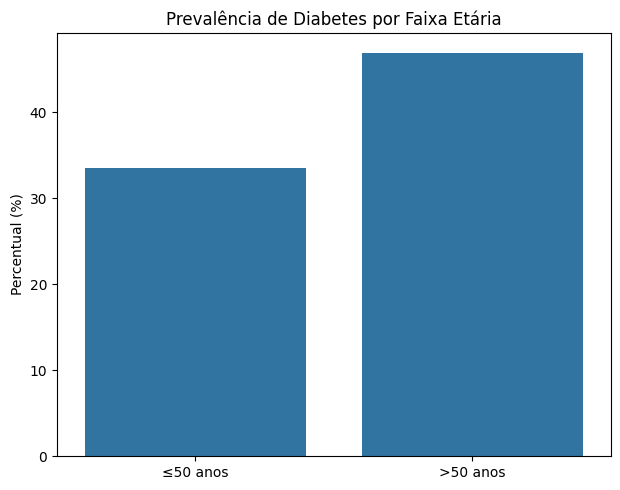

In [ ]:
plt.figure(figsize=(12, 5))

# Gráfico de barras
plt.subplot(1, 2, 1)
sns.barplot(x='Faixa_Etaria', y='Outcome', data=df,
            estimator=lambda x: sum(x)/len(x)*100,
            errorbar=None)
plt.title('Prevalência de Diabetes por Faixa Etária')
plt.ylabel('Percentual (%)')
plt.xlabel('')


plt.tight_layout()
plt.show()

#### 9.2 Conclusão

Observamos que sim, pessoas acima de 50 têm mais risco de ter diabetes. Quase 50% das pessoas acima dessa faixa etária possuem diabetes, vs os quase 35% em quem tem menos de 50 anos. Esse achado fortacele a correlação encontrada anteriormente, em que pessoas com diabetes são em média 6 anos mais velhas.

### Questão 10

Utilize regressão logística para estimar a probabilidade de um paciente ser
diagnosticado com diabetes. Quais variáveis são mais influentes no modelo e
como elas impactam a probabilidade de diagnóstico?

#### 10.1 Preparação e treinamento do modelo



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Selecionar variáveis e target
X = df.drop(['Outcome', 'Age', 'risco_familiar', 'Faixa_Etaria'], axis=1, errors='ignore')
y = df['Outcome']

# Padronizar as features (importante para regressão logística)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treinar o modelo
modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
modelo_lr.fit(X_scaled, y)

LogisticRegression(max_iter=1000, random_state=42)

#### 10.2 Análise das variáveis mais influentes

In [ ]:
# Coeficientes do modelo
coeficientes = pd.DataFrame({
    'Variável': X.columns,
    'Coeficiente': modelo_lr.coef_[0],
    'Magnitude': np.abs(modelo_lr.coef_[0]),
    'Odds_Ratio': np.exp(modelo_lr.coef_[0])
}).sort_values('Magnitude', ascending=False)

print(coeficientes)

                   Variável  Coeficiente  Magnitude  Odds_Ratio
1                   Glucose     1.120101   1.120101    3.065163
5                       BMI     0.513933   0.513933    1.671854
0               Pregnancies     0.476965   0.476965    1.611177
6  DiabetesPedigreeFunction     0.345402   0.345402    1.412558
3             SkinThickness     0.102015   0.102015    1.107400
2             BloodPressure    -0.039431   0.039431    0.961337
4                   Insulin    -0.031199   0.031199    0.969283


#### 10.3 Visualização dos resultados

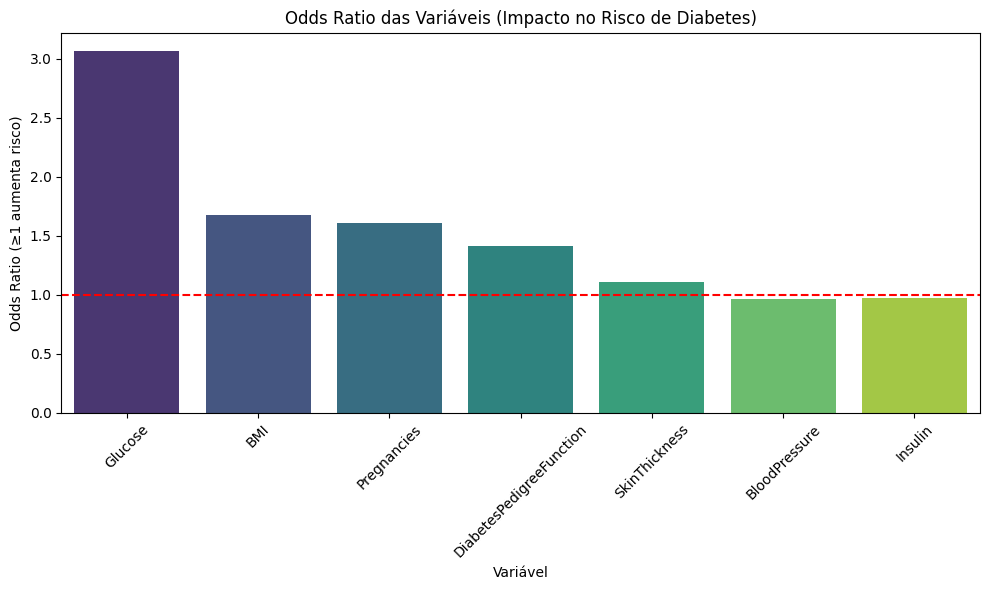

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=coeficientes, x='Variável', y='Odds_Ratio',
            hue='Variável', palette='viridis', legend=False)
plt.axhline(y=1, color='red', linestyle='--')
plt.title('Odds Ratio das Variáveis (Impacto no Risco de Diabetes)')
plt.ylabel('Odds Ratio (≥1 aumenta risco)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 10.4 Interpretação

Observamos que algumas variáveis possuem um impacto aparente diferente do esperado. Por que o ranking das variáveis nesse modelo difere da correlação encontrada anteriormente entre as variáveis e a presença da doença? A resposta se dá pela diferença entre análise bivariada (correlação simples) e modelagem multivariada (regressão logística), que consideram relações distintas entre as variáveis:

1)Correlação simples: Mede a associação individual entre cada variável e o outcome, sem considerar outras variáveis. Ex: A correlação positiva de insulin (0.24) indica que isoladamente, esssa variável está associada a mais casos de diabetes.

2)Regressão Logística: Mede o impacto isolado de cada variável ajustado pelas demais. Ex: O impacto reduzido de insulin mostra que, quando analisamos pela glicose e IMC, a insulina não tem impacto adicional significativo. Isso não significa que seja irrelevante clinicamente, mas que seu efeito é mediado por outras variáveis no modelo.

Dessa forma, as principais varíaveis observadas se alinham com o que é medicamente reconhecido: hiperglicemia, obesidade e fatores hereditários são os principais marcadores da doença. Pacientes com hiperglicemia, por exemplo, têm 200% mais chance de desenvolver diabetes (Odds ratio = 3.06)

### Questão 11

Quais técnicas de feature engineering podem ser aplicadas para melhorar a
previsão do diagnóstico de diabetes utilizando modelos de aprendizado de
máquina? Experimente transformar variáveis existentes, criar novas variáveis a
partir de combinações ou interações e utilize técnicas como encoding,
normalização ou transformação de características. Avalie o impacto dessas
mudanças no desempenho de um modelo de aprendizado de máquina (por
exemplo, Random Forest ou XGBoost).

#### 11.1 Criação de novas features

Razão glicemia/insulina -> indicador de resistencia insulínica.

Glicemia x histórico familiar -> pacientes com as 2 características podem ter risco maior.

In [ ]:
df['Glucose_Insuline_Ratio'] = df['Glucose'] / (df['Insulin'] + 1e-6)  # Evitar divisão por zero (just in case)
df['Glucose_x_DiabetesPedigree'] = df['Glucose'] * df['DiabetesPedigreeFunction']

# Definir X incluindo as variáveis novas
X_new = df[['Glucose', 'BMI', 'DiabetesPedigreeFunction','Age', 'Pregnancies','BloodPressure','SkinThickness','Insulin','Glucose_Insuline_Ratio', 'Glucose_x_DiabetesPedigree']]
y_new = df['Outcome']

#### 11.2 Treinando o modelo e vendo a importância de cada variável

In [ ]:
# Treinar modelo e obter importância
model = RandomForestClassifier(random_state=42)
model.fit(X_new, y_new)

# Corrigido: usar X_new.columns em vez de X.columns
feature_importance = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

                      Feature  Importance
0                     Glucose    0.223032
1                         BMI    0.132576
9  Glucose_x_DiabetesPedigree    0.127017
3                         Age    0.113488
8      Glucose_Insuline_Ratio    0.083862
2    DiabetesPedigreeFunction    0.075633
4                 Pregnancies    0.068156
5               BloodPressure    0.063080
7                     Insulin    0.060619
6               SkinThickness    0.052538


#### 11.3 Visualização

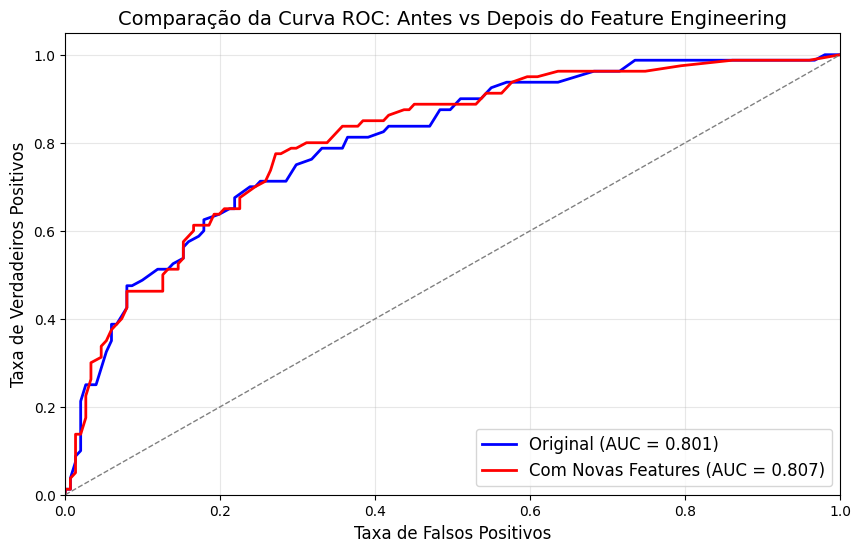

In [ ]:
# Dividir os dados (70% treino, 30% teste)
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_new, X_test_new, _, _ = train_test_split(X_new, y, test_size=0.3, random_state=42)

#Modelo Original
model_orig = RandomForestClassifier(random_state=42)
model_orig.fit(X_train_orig, y_train)
y_probs_orig = model_orig.predict_proba(X_test_orig)[:, 1]

#Modelo com Novas Features
model_new = RandomForestClassifier(random_state=42)
model_new.fit(X_train_new, y_train)
y_probs_new = model_new.predict_proba(X_test_new)[:, 1]

#Curvas ROC
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_probs_orig)
roc_auc_orig = auc(fpr_orig, tpr_orig)

fpr_new, tpr_new, _ = roc_curve(y_test, y_probs_new)
roc_auc_new = auc(fpr_new, tpr_new)

#Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_orig, tpr_orig, color='blue', lw=2,
         label=f'Original (AUC = {roc_auc_orig:.3f})')
plt.plot(fpr_new, tpr_new, color='red', lw=2,
         label=f'Com Novas Features (AUC = {roc_auc_new:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Comparação da Curva ROC: Antes vs Depois do Feature Engineering', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

#### 11.4 Conclusões


Os achados confirmam que a glicemia é o principal fator de risco da doença. Ademais, as novas features criadas tiveram impacto significativo, em que     Glucose_x_DiabetesPedigree foi rankeada no 3º lugar com 12.7% de importância, e Glucose_Insuline_Ratio obteve o 4º lugar, com 8.3% de importância. Ou seja, a interação entre glicose e histórico familiar é clinicamente relevante, e a razão glicose/insulina também ajuda, mas menos que o esperado.

Ademais, houve um aumento de 2.15% quando comparando as curvas ROC dos modelos. Embora o aumento pareça pequeno, em modelos de saúde, um ganho de 2% na AUC pode ser relevante, especialmente se reduzir o índice de falsos negativos. Um dos motivos da falta de um aumento ainda maior pode ser o overlap de informação, já que as variáveis novas estão relacionadas com Glucose, que já captura grande parte do risco. Além disso o tamanho relativamente pequeno do dataset pode ter contribuído para o ganho marginal de desempenho.